# CellChat cell-cell communication
# EDAD Niche 2 SPP1

In [1]:
library(CellChat)

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: igraph


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Loading required package: ggplot2



In [2]:
suppressMessages({
    library(plyr)
    library(CellChat)
    library(patchwork)
    library(SeuratDisk)
    library(Seurat)
    library(SingleCellExperiment)
    library(ggalluvial)
    library(repr)
    library(ggplot2)
    library(gplots)
    library(RColorBrewer)
    library(gplots)
    library(tidyr)
 })
options(stringsAsFactors = FALSE)

In [3]:
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [4]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Red Hat Enterprise Linux 8.5 (Ootpa)

Matrix products: default
BLAS/LAPACK: /rds/general/user/snb20/home/anaconda3/envs/r405_cellchat/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_GB.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_GB.UTF-8        LC_COLLATE=en_GB.UTF-8    
 [5] LC_MONETARY=en_GB.UTF-8    LC_MESSAGES=en_GB.UTF-8   
 [7] LC_PAPER=en_GB.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_GB.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
 [1] grid      stats4    parallel  stats     graphics  grDevices utils    
 [8] datasets  methods   base     

other attached packages:
 [1] ComplexHeatmap_2.6.2        tidyr_1.1.4                
 [3] RColorBrewer_1.1-2          gplots_3.1.1               
 [5] repr_1.1.4                  ggalluvial_0.12.3          
 [7] SingleCellExperiment_1.12.0 SummarizedEx

In [5]:
'%!in%' <- function(x,y)!('%in%'(x,y))

In [6]:
options(future.globals.maxSize = 20000 * 1024 ^ 2)

In [7]:
OUTDIR <- "/rds/general/user/snb20/home/3_COVID19/GitHub_Notebooks/CellChat/"
dir.create(OUTDIR, showWarnings = FALSE)
setwd(OUTDIR)
getwd()

[1] "/rds/general/user/snb20/home/3_COVID19/GitHub_Notebooks/CellChat"

In [8]:
#INDIR <- "/rds/general/user/snb20/home/3_COVID19/GitHub_Notebooks/CellChat/"

In [9]:
cellchat.healthy <- readRDS("/rds/general/user/snb20/projects/cardiac_single_cell_biology/live/sanger_covid19_snRNAseq/lung/lung_v2/object_anno/cellchat_global_healthy_no_abundance.rds")
cellchat.covid <- readRDS("/rds/general/user/snb20/projects/cardiac_single_cell_biology/live/sanger_covid19_snRNAseq/lung/lung_v2/object_anno/cellchat_global_covid_no_abundance.rds")

In [10]:
netVisual_bubble_2 <- function(object, sources.use = NULL, targets.use = NULL, signaling = NULL, pairLR.use = NULL, color.heatmap = c("Spectral","viridis","Reds"), n.colors = 10, direction = -1, thresh = 0.05,
                             comparison = NULL, group = NULL, remove.isolate = FALSE, max.dataset = NULL, min.dataset = NULL,
                             min.quantile = 0, max.quantile = 1, line.on = TRUE, line.size = 0.2, color.text.use = TRUE, color.text = NULL,
                             title.name = NULL, font.size = 10, font.size.title = 10, show.legend = TRUE,
                             grid.on = TRUE, color.grid = "grey90", angle.x = 90, vjust.x = NULL, hjust.x = NULL,angle.y = 0, vjust.y = NULL, hjust.y = NULL,
                             return.data = FALSE,text_size.x=8,text_size.y=8,pch=16,cex=1,order=NULL){
  color.heatmap <- match.arg(color.heatmap)
  if (is.list(object@net[[1]])) {
    message("Comparing communications on a merged object \n")
  } else {
    message("Comparing communications on a single object \n")
  }
  if (is.null(vjust.x) | is.null(hjust.x)) {
    angle=c(0, 45, 90)
    hjust=c(0, 1, 1)
    vjust=c(0, 1, 0.5)
    vjust.x = vjust[angle == angle.x]
    hjust.x = hjust[angle == angle.x]
  }
  if (length(color.heatmap) == 1) {
    color.use <- tryCatch({
      RColorBrewer::brewer.pal(n = n.colors, name = color.heatmap)
    }, error = function(e) {
      scales::viridis_pal(option = color.heatmap, direction = -1)(n.colors)
    })
  } else {
    color.use <- color.heatmap
  }
  if (direction == -1) {
    color.use <- rev(color.use)
  }

  if (is.null(comparison)) {
    cells.level <- levels(object@idents)
    if (is.numeric(sources.use)) {
      sources.use <- cells.level[sources.use]
    }
    if (is.numeric(targets.use)) {
      targets.use <- cells.level[targets.use]
    }
    df.net <- subsetCommunication(object, slot.name = "net",
                                  sources.use = sources.use, targets.use = targets.use,
                                  signaling = signaling,
                                  pairLR.use = pairLR.use,
                                  thresh = thresh)
    df.net$source.target <- paste(df.net$source, df.net$target, sep = " -> ")
    source.target <- paste(rep(sources.use, each = length(targets.use)), targets.use, sep = " -> ")
    source.target.isolate <- setdiff(source.target, unique(df.net$source.target))
    if (length(source.target.isolate) > 0) {
      df.net.isolate <- as.data.frame(matrix(NA, nrow = length(source.target.isolate), ncol = ncol(df.net)))
      colnames(df.net.isolate) <- colnames(df.net)
      df.net.isolate$source.target <- source.target.isolate
      df.net.isolate$interaction_name_2 <- df.net$interaction_name_2[1]
      df.net.isolate$pval <- 1
      a <- stringr::str_split(df.net.isolate$source.target, " -> ", simplify = T)
      df.net.isolate$source <- as.character(a[, 1])
      df.net.isolate$target <- as.character(a[, 2])
      df.net <- rbind(df.net, df.net.isolate)
    }

    df.net$pval[df.net$pval > 0.05] = 1
    df.net$pval[df.net$pval > 0.01 & df.net$pval <= 0.05] = 2
    df.net$pval[df.net$pval <= 0.01] = 3
    df.net$prob[df.net$prob == 0] <- NA
    df.net$prob.original <- df.net$prob
    df.net$prob <- -1/log(df.net$prob)

    idx1 <- which(is.infinite(df.net$prob) | df.net$prob < 0)
    if (sum(idx1) > 0) {
      values.assign <- seq(max(df.net$prob, na.rm = T)*1.1, max(df.net$prob, na.rm = T)*1.5, length.out = length(idx1))
      position <- sort(prob.original[idx1], index.return = TRUE)$ix
      df.net$prob[idx1] <- values.assign[match(1:length(idx1), position)]
    }
    # rownames(df.net) <- df.net$interaction_name_2

    df.net$source <- factor(df.net$source, levels = cells.level[cells.level %in% unique(df.net$source)])
    df.net$target <- factor(df.net$target, levels = cells.level[cells.level %in% unique(df.net$target)])
    group.names <- paste(rep(levels(df.net$source), each = length(levels(df.net$target))), levels(df.net$target), sep = " -> ")

    df.net$interaction_name_2 <- as.character(df.net$interaction_name_2)
    df.net <- with(df.net, df.net[order(interaction_name_2),])
    df.net$interaction_name_2 <- factor(df.net$interaction_name_2, levels = unique(df.net$interaction_name_2))
    cells.order <- group.names
    df.net$source.target <- factor(df.net$source.target, levels = cells.order)
    df <- df.net
  } else {
    dataset.name <- names(object@net)
    df.net.all <- subsetCommunication(object, slot.name = "net",
                                      sources.use = sources.use, targets.use = targets.use,
                                      signaling = signaling,
                                      pairLR.use = pairLR.use,
                                      thresh = thresh)
    df.all <- data.frame()
    for (ii in 1:length(comparison)) {
      cells.level <- levels(object@idents[[comparison[ii]]])
      if (is.numeric(sources.use)) {
        sources.use <- cells.level[sources.use]
      }
      if (is.numeric(targets.use)) {
        targets.use <- cells.level[targets.use]
      }

      df.net <- df.net.all[[comparison[ii]]]
      df.net$interaction_name_2 <- as.character(df.net$interaction_name_2)
      df.net$source.target <- paste(df.net$source, df.net$target, sep = " -> ")
      source.target <- paste(rep(sources.use, each = length(targets.use)), targets.use, sep = " -> ")
      source.target.isolate <- setdiff(source.target, unique(df.net$source.target))
      if (length(source.target.isolate) > 0) {
        df.net.isolate <- as.data.frame(matrix(NA, nrow = length(source.target.isolate), ncol = ncol(df.net)))
        colnames(df.net.isolate) <- colnames(df.net)
        df.net.isolate$source.target <- source.target.isolate
        df.net.isolate$interaction_name_2 <- df.net$interaction_name_2[1]
        df.net.isolate$pval <- 1
        a <- stringr::str_split(df.net.isolate$source.target, " -> ", simplify = T)
        df.net.isolate$source <- as.character(a[, 1])
        df.net.isolate$target <- as.character(a[, 2])
        df.net <- rbind(df.net, df.net.isolate)
      }

      df.net$source <- factor(df.net$source, levels = cells.level[cells.level %in% unique(df.net$source)])
      df.net$target <- factor(df.net$target, levels = cells.level[cells.level %in% unique(df.net$target)])
      group.names <- paste(rep(levels(df.net$source), each = length(levels(df.net$target))), levels(df.net$target), sep = " -> ")
      group.names0 <- group.names
      group.names <- paste0(group.names0, " (", dataset.name[comparison[ii]], ")")

      if (nrow(df.net) > 0) {
        df.net$pval[df.net$pval > 0.05] = 1
        df.net$pval[df.net$pval > 0.01 & df.net$pval <= 0.05] = 2
        df.net$pval[df.net$pval <= 0.01] = 3
        df.net$prob[df.net$prob == 0] <- NA
        df.net$prob.original <- df.net$prob
        df.net$prob <- -1/log(df.net$prob)
      } else {
        df.net <- as.data.frame(matrix(NA, nrow = length(group.names), ncol = 5))
        colnames(df.net) <- c("interaction_name_2","source.target","prob","pval","prob.original")
        df.net$source.target <- group.names0
      }
      # df.net$group.names <- sub(paste0(' \\(',dataset.name[comparison[ii]],'\\)'),'',as.character(df.net$source.target))
      df.net$group.names <- as.character(df.net$source.target)
      df.net$source.target <- paste0(df.net$source.target, " (", dataset.name[comparison[ii]], ")")
      df.net$dataset <- dataset.name[comparison[ii]]
      df.all <- rbind(df.all, df.net)
    }
    if (nrow(df.all) == 0) {
      stop("No interactions are detected. Please consider changing the cell groups for analysis. ")
    }

    idx1 <- which(is.infinite(df.all$prob) | df.all$prob < 0)
    if (sum(idx1) > 0) {
      values.assign <- seq(max(df.all$prob, na.rm = T)*1.1, max(df.all$prob, na.rm = T)*1.5, length.out = length(idx1))
      position <- sort(df.all$prob.original[idx1], index.return = TRUE)$ix
      df.all$prob[idx1] <- values.assign[match(1:length(idx1), position)]
    }

    df.all$interaction_name_2[is.na(df.all$interaction_name_2)] <- df.all$interaction_name_2[!is.na(df.all$interaction_name_2)][1]

    df <- df.all
    df <- with(df, df[order(interaction_name_2),])
    df$interaction_name_2 <- factor(df$interaction_name_2, levels = unique(df$interaction_name_2))

    cells.order <- c()
    dataset.name.order <- c()
    for (i in 1:length(group.names0)) {
      for (j in 1:length(comparison)) {
        cells.order <- c(cells.order, paste0(group.names0[i], " (", dataset.name[comparison[j]], ")"))
        dataset.name.order <- c(dataset.name.order, dataset.name[comparison[j]])
      }
    }
    df$source.target <- factor(df$source.target, levels = cells.order)
  }

  min.cutoff <- quantile(df$prob, min.quantile,na.rm= T)
  max.cutoff <- quantile(df$prob, max.quantile,na.rm= T)
  df$prob[df$prob < min.cutoff] <- min.cutoff
  df$prob[df$prob > max.cutoff] <- max.cutoff


  if (remove.isolate) {
    df <- df[!is.na(df$prob), ]
    line.on <- FALSE
  }
  if (!is.null(max.dataset)) {
    # line.on <- FALSE
    # df <- df[!is.na(df$prob),]
    signaling <- as.character(unique(df$interaction_name_2))
    for (i in signaling) {
      df.i <- df[df$interaction_name_2 == i, ,drop = FALSE]
      cell <- as.character(unique(df.i$group.names))
      for (j in cell) {
        df.i.j <- df.i[df.i$group.names == j, , drop = FALSE]
        values <- df.i.j$prob
        idx.max <- which(values == max(values, na.rm = T))
        idx.min <- which(values == min(values, na.rm = T))
        #idx.na <- c(which(is.na(values)), which(!(dataset.name[comparison] %in% df.i.j$dataset)))
        dataset.na <- c(df.i.j$dataset[is.na(values)], setdiff(dataset.name[comparison], df.i.j$dataset))
        if (length(idx.max) > 0) {
          if (!(df.i.j$dataset[idx.max] %in% dataset.name[max.dataset])) {
            df.i.j$prob <- NA
          } else if ((idx.max != idx.min) & !is.null(min.dataset)) {
            if (!(df.i.j$dataset[idx.min] %in% dataset.name[min.dataset])) {
              df.i.j$prob <- NA
            } else if (length(dataset.na) > 0 & sum(!(dataset.name[min.dataset] %in% dataset.na)) > 0) {
              df.i.j$prob <- NA
            }
          }
        }
        df.i[df.i$group.names == j, "prob"] <- df.i.j$prob
      }
      df[df$interaction_name_2 == i, "prob"] <- df.i$prob
    }
    #df <- df[!is.na(df$prob), ]
  }
  if (remove.isolate) {
    df <- df[!is.na(df$prob), ]
    line.on <- FALSE
  }
  if (nrow(df) == 0) {
    stop("No interactions are detected. Please consider changing the cell groups for analysis. ")
  }
  df$interaction_name_2 <- factor(df$interaction_name_2, levels = unique(df$interaction_name_2))
  df$source.target = droplevels(df$source.target, exclude = setdiff(levels(df$source.target),unique(df$source.target)))
   
  if (!is.null(order)){
      
     df=df[
     with(df, order(df$dataset,df$target)),
     ]
     df$source.target=paste0(df$group.names," (",df$dataset,")")
      if (order==TRUE){
     order=unique(df$source.target)
          }
     df$source.target <- factor(df$source.target,levels = c(order))

  }

    if (!is.null(cex)){
   
  g <- ggplot(df, aes(y = source.target, x = interaction_name_2, color = prob, size = pval)) +
    geom_point(pch = pch,cex=cex) +
    theme_linedraw() + theme(panel.grid.major = element_blank()) +
    theme(axis.text.x = element_text(angle = angle.x, hjust= hjust.x, vjust = vjust.x,size=text_size.x),
          axis.text.y = element_text(angle = angle.y, hjust= hjust.y, vjust = vjust.y,size=text_size.y),
          axis.title.x = element_blank(),
          axis.title.y = element_blank()) +
    scale_x_discrete(position = "bottom")
        }
    
     if (is.null(cex)){
   
  g <- ggplot(df, aes(y = source.target, x = interaction_name_2, color = prob, size = pval)) +
    geom_point(pch = pch) +
    theme_linedraw() + theme(panel.grid.major = element_blank()) +
    theme(axis.text.x = element_text(angle = angle.x, hjust= hjust.x, vjust = vjust.x,size=text_size.x),
          axis.text.y = element_text(angle = angle.y, hjust= hjust.y, vjust = vjust.y,size=text_size.y),
          axis.title.x = element_blank(),
          axis.title.y = element_blank()) +
    scale_x_discrete(position = "bottom")
        }

  values <- c(1,2,3); names(values) <- c("p > 0.05", "0.01 < p < 0.05","p < 0.01")

  g <- g + scale_radius(range = c(min(df$pval), max(df$pval)), breaks = sort(unique(df$pval)),labels = names(values)[values %in% sort(unique(df$pval))], name = "p-value")
  #g <- g + scale_radius(range = c(1,3), breaks = values,labels = names(values), name = "p-value")
  if (min(df$prob, na.rm = T) != max(df$prob, na.rm = T)) {
    g <- g + scale_colour_gradientn(colors = colorRampPalette(color.use)(99), na.value = "white", limits=c(quantile(df$prob, 0,na.rm= T), quantile(df$prob, 1,na.rm= T)),
                                    breaks = c(quantile(df$prob, 0,na.rm= T), quantile(df$prob, 1,na.rm= T)), labels = c("min","max")) +
      guides(color = guide_colourbar(barwidth = 0.5, title = "Commun. Prob."))
  } else {
    g <- g + scale_colour_gradientn(colors = colorRampPalette(color.use)(99), na.value = "white") +
      guides(color = guide_colourbar(barwidth = 0.5, title = "Commun. Prob."))
  }

  g <- g + theme(text = element_text(size = font.size),plot.title = element_text(size=font.size.title)) +
    theme(legend.title = element_text(size = 8), legend.text = element_text(size = 6))

  if (grid.on) {
    if (length(unique(df$source.target)) > 1) {
      g <- g + geom_vline(xintercept=seq(1.5, length(unique(df$source.target))-0.5, 1),lwd=0.1,colour=color.grid)
    }
    if (length(unique(df$interaction_name_2)) > 1) {
      g <- g + geom_hline(yintercept=seq(1.5, length(unique(df$interaction_name_2))-0.5, 1),lwd=0.1,colour=color.grid)
    }
  }
  if (!is.null(title.name)) {
    g <- g + ggtitle(title.name) + theme(plot.title = element_text(hjust = 0.5))
  }

  if (!is.null(comparison)) {
    if (line.on) {
      xintercept = seq(0.5+length(dataset.name[comparison]), length(group.names0)*length(dataset.name[comparison]), by = length(dataset.name[comparison]))
      g <- g + geom_vline(xintercept = xintercept, linetype="dashed", color = "grey60", size = line.size)
    }
    if (color.text.use) {
      if (is.null(group)) {
        group <- 1:length(comparison)
        names(group) <- dataset.name[comparison]
      }
      if (is.null(color.text)) {
        color <- ggPalette(length(unique(group)))
      } else {
        color <- color.text
      }
      names(color) <- names(group[!duplicated(group)])
      color <- color[group]
      #names(color) <- dataset.name[comparison]
      dataset.name.order <- levels(df$source.target)
      dataset.name.order <- stringr::str_match(dataset.name.order, "\\(.*\\)")
      dataset.name.order <- stringr::str_sub(dataset.name.order, 2, stringr::str_length(dataset.name.order)-1)
      xtick.color <- color[dataset.name.order]
      g <- g + theme(axis.text.x = element_text(colour = xtick.color))
    }
  }
  if (!show.legend) {
    g <- g + theme(legend.position = "none")
  }
  if (return.data) {
    return(list(communication = df, gg.obj = g))
  } else {
    return(g)
  }

}

In [11]:
netVisual_diffInteraction <- function(object, comparison = c(1,2), measure = c("count", "weight", "count.merged", "weight.merged"), color.use = NULL, color.edge = c('#b2182b','#2166ac'), title.name = NULL, sources.use = NULL, targets.use = NULL, remove.isolate = FALSE, top = 1,
                                      weight.scale = FALSE, vertex.weight = 20, vertex.weight.max = NULL, vertex.size.max = 15, vertex.label.cex=1,vertex.label.color= "black",
                                      edge.weight.max = NULL, edge.width.max=8, alpha.edge = 0.6, label.edge = FALSE,edge.label.color='black',edge.label.cex=0.8,
                                      edge.curved=0.2,shape='circle',layout=in_circle(), margin=0.2,
                                      arrow.width=1,arrow.size = 0.2){
  options(warn = -1)
  measure <- match.arg(measure)
  obj1 <- object@net[[comparison[1]]][[measure]]
  obj2 <- object@net[[comparison[2]]][[measure]]
  net.diff <- obj2 - obj1
  if (measure %in% c("count", "count.merged")) {
    if (is.null(title.name)) {
      title.name = "Differential number of interactions"
    }
  } else if (measure %in% c("weight", "weight.merged")) {
    if (is.null(title.name)) {
      title.name = "Differential interaction strength"
    }
  }
  net <- net.diff
  if ((!is.null(sources.use)) | (!is.null(targets.use))) {
    df.net <- reshape2::melt(net, value.name = "value")
    colnames(df.net)[1:2] <- c("source","target")
    # keep the interactions associated with sources and targets of interest
    if (!is.null(sources.use)){
      if (is.numeric(sources.use)) {
        sources.use <- rownames(net.diff)[sources.use]
      }
      df.net <- subset(df.net, source %in% sources.use)
    }
    if (!is.null(targets.use)){
      if (is.numeric(targets.use)) {
        targets.use <- rownames(net.diff)[targets.use]
      }
      df.net <- subset(df.net, target %in% targets.use)
    }
    cells.level <- rownames(net.diff)
    df.net$source <- factor(df.net$source, levels = cells.level)
    df.net$target <- factor(df.net$target, levels = cells.level)
    df.net$value[is.na(df.net$value)] <- 0
    net <- tapply(df.net[["value"]], list(df.net[["source"]], df.net[["target"]]), sum)
  }
    net[is.na(net)] <- 0

  if (remove.isolate) {
    idx1 <- which(Matrix::rowSums(net) == 0)
    idx2 <- which(Matrix::colSums(net) == 0)
    idx <- intersect(idx1, idx2)
    net <- net[-idx, ]
    net <- net[, -idx]
  }

  net[abs(net) < stats::quantile(abs(net), probs = 1-top)] <- 0

  g <- graph_from_adjacency_matrix(net, mode = "directed", weighted = T)
  edge.start <- igraph::ends(g, es=igraph::E(g), names=FALSE)
  coords<-layout_(g,layout)
  if(nrow(coords)!=1){
    coords_scale=scale(coords)
  }else{
    coords_scale<-coords
  }
  if (is.null(color.use)) {
    color.use = scPalette(length(igraph::V(g)))
  }
  if (is.null(vertex.weight.max)) {
    vertex.weight.max <- max(vertex.weight)
  }
  vertex.weight <- vertex.weight/vertex.weight.max*vertex.size.max+5

  loop.angle<-ifelse(coords_scale[igraph::V(g),1]>0,-atan(coords_scale[igraph::V(g),2]/coords_scale[igraph::V(g),1]),pi-atan(coords_scale[igraph::V(g),2]/coords_scale[igraph::V(g),1]))
  igraph::V(g)$size<-vertex.weight
  igraph::V(g)$color<-color.use[igraph::V(g)]
  igraph::V(g)$frame.color <- color.use[igraph::V(g)]
  igraph::V(g)$label.color <- vertex.label.color
  igraph::V(g)$label.cex<-vertex.label.cex
  if(label.edge){
    igraph::E(g)$label<-igraph::E(g)$weight
    igraph::E(g)$label <- round(igraph::E(g)$label, digits = 1)
  }
  igraph::E(g)$arrow.width<-arrow.width
  igraph::E(g)$arrow.size<-arrow.size
  igraph::E(g)$label.color<-edge.label.color
  igraph::E(g)$label.cex<-edge.label.cex
  #igraph::E(g)$color<- grDevices::adjustcolor(igraph::V(g)$color[edge.start[,1]],alpha.edge)
  igraph::E(g)$color <- ifelse(igraph::E(g)$weight > 0, color.edge[1],color.edge[2])
  igraph::E(g)$color <- grDevices::adjustcolor(igraph::E(g)$color, alpha.edge)

  igraph::E(g)$weight <- abs(igraph::E(g)$weight)

  if (is.null(edge.weight.max)) {
    edge.weight.max <- max(igraph::E(g)$weight)
  }
  if (weight.scale == TRUE) {
    #E(g)$width<-0.3+edge.width.max/(max(E(g)$weight)-min(E(g)$weight))*(E(g)$weight-min(E(g)$weight))
    igraph::E(g)$width<- 0.3+igraph::E(g)$weight/edge.weight.max*edge.width.max
  }else{
    igraph::E(g)$width<-0.3+edge.width.max*igraph::E(g)$weight
  }


  if(sum(edge.start[,2]==edge.start[,1])!=0){
    igraph::E(g)$loop.angle[which(edge.start[,2]==edge.start[,1])]<-loop.angle[edge.start[which(edge.start[,2]==edge.start[,1]),1]]
  }
  radian.rescale <- function(x, start=0, direction=1) {
    c.rotate <- function(x) (x + start) %% (2 * pi) * direction
    c.rotate(scales::rescale(x, c(0, 2 * pi), range(x)))
  }
  label.locs <- radian.rescale(x=1:length(igraph::V(g)), direction=-1, start=0)
  label.dist <- vertex.weight/max(vertex.weight)+2
  plot(g,edge.curved=edge.curved,vertex.shape=shape,layout=coords_scale,margin=margin, vertex.label.dist=label.dist,
       vertex.label.degree=label.locs, vertex.label.family="Helvetica", edge.label.family="Helvetica") # "sans"
  if (!is.null(title.name)) {
    text(0,1.5,title.name, cex = 1.1)
  }
  # https://www.andrewheiss.com/blog/2016/12/08/save-base-graphics-as-pseudo-objects-in-r/
  # grid.echo()
  # gg <-  grid.grab()
  gg <- recordPlot()
  return(gg)
}


In [12]:
netVisual_circle <-function(net, color.use = NULL,title.name = NULL, sources.use = NULL, targets.use = NULL, idents.use = NULL, remove.isolate = FALSE, top = 1,
                            weight.scale = FALSE, vertex.weight = 20, vertex.weight.max = NULL, vertex.size.max = NULL, vertex.label.cex=1,vertex.label.color= "black",
                            edge.weight.max = NULL, edge.width.max=8, alpha.edge = 0.6, label.edge = FALSE,edge.label.color='black',edge.label.cex=0.8,
                            edge.curved=0.2,shape='circle',layout=in_circle(), margin=0.2, vertex.size = NULL,
                            arrow.width=1,arrow.size = 1,arrow.color="black"){
  if (!is.null(vertex.size)) {
    warning("'vertex.size' is deprecated. Use `vertex.weight`")
  }
  if (is.null(vertex.size.max)) {
    if (length(unique(vertex.weight)) == 1) {
      vertex.size.max <- 5
    } else {
      vertex.size.max <- 15
    }
  }
  options(warn = -1)
  thresh <- stats::quantile(net, probs = 1-top)
  net[net < thresh] <- 0

  if ((!is.null(sources.use)) | (!is.null(targets.use)) | (!is.null(idents.use)) ) {
    if (is.null(rownames(net))) {
      stop("The input weighted matrix should have rownames!")
    }
    cells.level <- rownames(net)
    df.net <- reshape2::melt(net, value.name = "value")
    colnames(df.net)[1:2] <- c("source","target")
    # keep the interactions associated with sources and targets of interest
    if (!is.null(sources.use)){
      if (is.numeric(sources.use)) {
        sources.use <- cells.level[sources.use]
      }
      df.net <- subset(df.net, source %in% sources.use)
    }
    if (!is.null(targets.use)){
      if (is.numeric(targets.use)) {
        targets.use <- cells.level[targets.use]
      }
      df.net <- subset(df.net, target %in% targets.use)
    }
    if (!is.null(idents.use)) {
      if (is.numeric(idents.use)) {
        idents.use <- cells.level[idents.use]
      }
      df.net <- filter(df.net, (source %in% idents.use) | (target %in% idents.use))
    }
    df.net$source <- factor(df.net$source, levels = cells.level)
    df.net$target <- factor(df.net$target, levels = cells.level)
    df.net$value[is.na(df.net$value)] <- 0
    net <- tapply(df.net[["value"]], list(df.net[["source"]], df.net[["target"]]), sum)
  }
  net[is.na(net)] <- 0


  if (remove.isolate) {
    idx1 <- which(Matrix::rowSums(net) == 0)
    idx2 <- which(Matrix::colSums(net) == 0)
    idx <- intersect(idx1, idx2)
    net <- net[-idx, ]
    net <- net[, -idx]
  }

  g <- graph_from_adjacency_matrix(net, mode = "directed", weighted = T)
  edge.start <- igraph::ends(g, es=igraph::E(g), names=FALSE)
  coords<-layout_(g,layout)
  if(nrow(coords)!=1){
    coords_scale=scale(coords)
  }else{
    coords_scale<-coords
  }
  if (is.null(color.use)) {
    color.use = scPalette(length(igraph::V(g)))
  }
  if (is.null(vertex.weight.max)) {
    vertex.weight.max <- max(vertex.weight)
  }
  vertex.weight <- vertex.weight/vertex.weight.max*vertex.size.max+5

  loop.angle<-ifelse(coords_scale[igraph::V(g),1]>0,-atan(coords_scale[igraph::V(g),2]/coords_scale[igraph::V(g),1]),pi-atan(coords_scale[igraph::V(g),2]/coords_scale[igraph::V(g),1]))
  igraph::V(g)$size<-vertex.weight
  igraph::V(g)$color<-color.use[igraph::V(g)]
  igraph::V(g)$frame.color <- color.use[igraph::V(g)]
  igraph::V(g)$label.color <- vertex.label.color
  igraph::V(g)$label.cex<-vertex.label.cex
  if(label.edge){
    igraph::E(g)$label<-igraph::E(g)$weight
    igraph::E(g)$label <- round(igraph::E(g)$label, digits = 1)
  }
  if (is.null(edge.weight.max)) {
    edge.weight.max <- max(igraph::E(g)$weight)
  }
  if (weight.scale == TRUE) {
    #E(g)$width<-0.3+edge.width.max/(max(E(g)$weight)-min(E(g)$weight))*(E(g)$weight-min(E(g)$weight))
    igraph::E(g)$width<- 0.3+igraph::E(g)$weight/edge.weight.max*edge.width.max
  }else{
    igraph::E(g)$width<-0.3+edge.width.max*igraph::E(g)$weight
  }

  igraph::E(g)$arrow.width<-arrow.width
  igraph::E(g)$arrow.size<-arrow.size
  igraph::E(g)$label.color<-edge.label.color
  igraph::E(g)$label.cex<-edge.label.cex
  #igraph::E(g)$color<- arrow.color
  igraph::E(g)$color<- alpha(arrow.color, alpha = alpha.edge)
    
  if(sum(edge.start[,2]==edge.start[,1])!=0){
    igraph::E(g)$loop.angle[which(edge.start[,2]==edge.start[,1])]<-loop.angle[edge.start[which(edge.start[,2]==edge.start[,1]),1]]
  }
  radian.rescale <- function(x, start=0, direction=1) {
    c.rotate <- function(x) (x + start) %% (2 * pi) * direction
    c.rotate(scales::rescale(x, c(0, 2 * pi), range(x)))
  }
  label.locs <- radian.rescale(x=1:length(igraph::V(g)), direction=-1, start=0)
  label.dist <- vertex.weight/max(vertex.weight)+2
  plot(g,edge.curved=edge.curved,vertex.shape=shape,layout=coords_scale,margin=margin, vertex.label.dist=label.dist,
       vertex.label.degree=label.locs, vertex.label.family="Helvetica", edge.label.family="Helvetica") # "sans"
  if (!is.null(title.name)) {
    text(0,1.5,title.name, cex = 1.1)
  }
  # https://www.andrewheiss.com/blog/2016/12/08/save-base-graphics-as-pseudo-objects-in-r/
  # grid.echo()
  # gg <-  grid.grab()
  gg <- recordPlot()
  return(gg)
}



In [13]:
covidsubset = subsetCellChat(cellchat.covid,idents.use=c('MYE.Macrophage.Alveolar.Metallothionein.CCL','FB.Alveolar','EP.AT1','EC.Capillary','EC.Aerocyte'))
signaling <- c("SPP1") 
covid = aggregateNet(covidsubset, signaling = signaling, remove.isolate = FALSE, sources.use = c('MYE.Macrophage.Alveolar.Metallothionein.CCL','FB.Alveolar','EP.AT1','EC.Capillary','EC.Aerocyte'), targets.use = c('MYE.Macrophage.Alveolar.Metallothionein.CCL','FB.Alveolar','EP.AT1','EC.Capillary','EC.Aerocyte'))
cellchat <- computeCommunProbPathway(covid)

The subset of cell groups used for CellChat analysis are  EP.AT1 EC.Capillary EC.Aerocyte FB.Alveolar MYE.Macrophage.Alveolar.Metallothionein.CCL 
Update slots object@net, object@netP in a single dataset... 


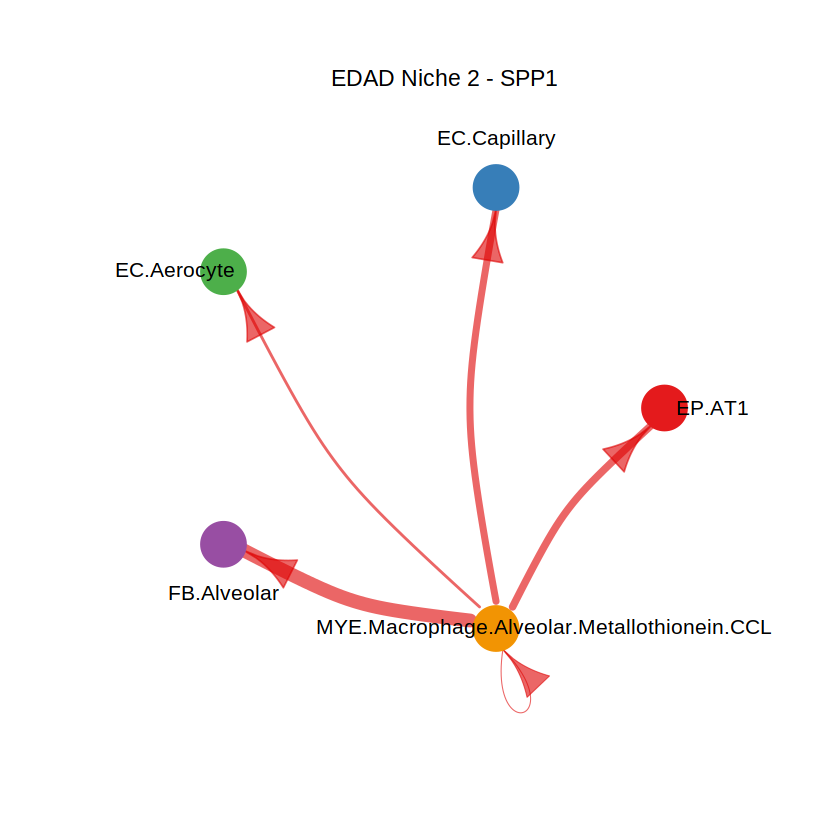

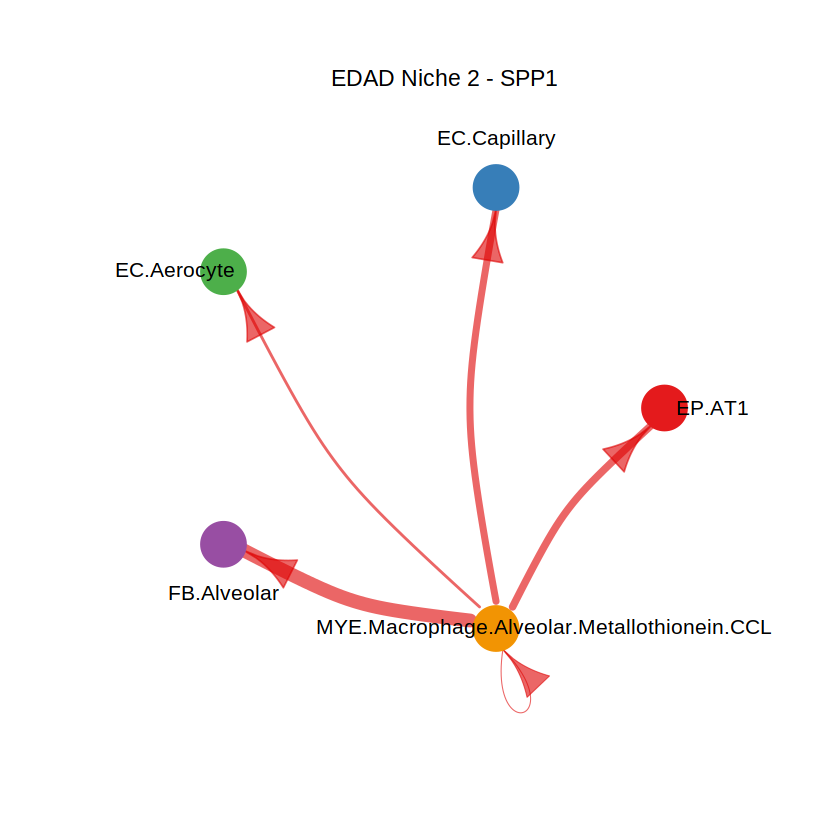

In [14]:
options(repr.plot.width = 7, repr.plot.height = 7)
netVisual_circle(cellchat@net$weight, weight.scale = T, label.edge= F, title.name = "EDAD Niche 2 - SPP1", arrow.color = "#DE0000", arrow.size = 2, alpha.edge = 0.6, vertex.size.max=15)

In [23]:
options(repr.plot.width =3.5, repr.plot.height = 6, repr.plot.res = 300)

pathways.show <- c("SPP1") 

pdf("SPP1_doplot_niche2.pdf", height = 6,width =3.5)

netVisual_bubble(cellchat, signaling = pathways.show, grid.on = FALSE, remove.isolate = TRUE)
dev.off()

Comparing communications on a single object 




png 
  2